In [3]:
# Trabajo Práctico N°3 - Big Data & Machine Learning
# Universidad de Buenos Aires, 2025
# Grupo: 1
# Región seleccionada: Gran Buenos Aires

# ----------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los archivos de datos
try:
    df_2004 = pd.read_stata('usu_individual_T104.dta')
    df_2024 = pd.read_excel('usu_individual_T124.xlsx')
except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}")
    raise

# Estandarizar nombres de columnas a mayúsculas
df_2004.columns = df_2004.columns.str.upper()
df_2024.columns = df_2024.columns.str.upper()

# Homogeneizar CH04: convertir a 'Hombre' / 'Mujer'
df_2004['CH04'] = df_2004['CH04'].replace({'Hombre': 'Hombre', 'Mujer': 'Mujer'})
df_2024['CH04'] = df_2024['CH04'].replace({1: 'Hombre', 2: 'Mujer'})

# Filtrar solo Gran Buenos Aires
df_2004['REGION'] = df_2004['REGION'].astype(str)
df_2024['REGION'] = df_2024['REGION'].astype(str)
df_2004 = df_2004[df_2004['REGION'] == 'Gran Buenos Aires']
df_2024 = df_2024[df_2024['REGION'] == '1']

# Agregar columna de año
df_2004['ANO4'] = 2004
df_2024['ANO4'] = 2024

# Seleccionar variables comunes
variables_comunes = [
    'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 
    'CAT_INAC', 'IPCF', 'P21', 'PP04D_COD', 'P47T', 'CH12', 'CH13', 'CH14',
    'REGION', 'AGLOMERADO', 'TRIMESTRE', 'ANO4'
]

# Convertir variables numéricas
numeric_vars = ['CH06', 'IPCF', 'P21', 'P47T']
for var in numeric_vars:
    if var in df_2004.columns:
        df_2004[var] = pd.to_numeric(df_2004[var], errors='coerce')
    if var in df_2024.columns:
        df_2024[var] = pd.to_numeric(df_2024[var], errors='coerce')

# Unir dataframes
df_combinado = pd.concat(
    [df_2004[variables_comunes], df_2024[variables_comunes]],
    ignore_index=True
)

# Verificar observaciones por año
print("Conteo de observaciones por año:")
print(df_combinado['ANO4'].value_counts())

# Análisis de valores faltantes
valores_faltantes = df_combinado[variables_comunes].isna().sum()
print("Valores faltantes por variable:")
print(valores_faltantes)

faltantes_por_anio = df_combinado.groupby("ANO4").apply(lambda df: df.isnull().sum())
faltantes_por_anio = faltantes_por_anio.transpose()
print("Valores faltantes por año:")
print(faltantes_por_anio)

# Comentario: La variable PP04D_COD tiene 3827 valores faltantes en 2024, probablemente porque no todas las personas respondieron sobre su ocupación específica. CH06 (edad) tiene 135 faltantes en 2004, lo que puede deberse a errores en la recolección de datos. P47T (ingreso total) tiene 41 faltantes en 2024, lo que refleja no respuestas.

# Limpieza de ingresos negativos
df_combinado['P47T'] = df_combinado['P47T'].apply(lambda x: x if x is None or x >= 0 else np.nan)
df_combinado['IPCF'] = df_combinado['IPCF'].apply(lambda x: x if x is None or x >= 0 else np.nan)

print("Cantidad de valores NaN en ingresos después de limpiar:")
print("P47T:", df_combinado['P47T'].isna().sum())
print("IPCF:", df_combinado['IPCF'].isna().sum())



Conteo de observaciones por año:
ANO4
2004    7647
2024    7051
Name: count, dtype: int64
Valores faltantes por variable:
CH04             0
CH06           135
CH07             0
CH08             0
NIVEL_ED         0
ESTADO           0
CAT_INAC         0
IPCF             0
P21              0
PP04D_COD     3827
P47T            41
CH12             0
CH13             0
CH14          3686
REGION           0
AGLOMERADO       0
TRIMESTRE        0
ANO4             0
dtype: int64
Valores faltantes por año:
ANO4        2004  2024
CH04           0     0
CH06         135     0
CH07           0     0
CH08           0     0
NIVEL_ED       0     0
ESTADO         0     0
CAT_INAC       0     0
IPCF           0     0
P21            0     0
PP04D_COD      0  3827
P47T           0    41
CH12           0     0
CH13           0     0
CH14           0  3686
REGION         0     0
AGLOMERADO     0     0
TRIMESTRE      0     0
ANO4           0     0
Cantidad de valores NaN en ingresos después de limpiar:
P47

In [4]:

# Normalizar ESTADO
estado_map = {
    1: "Ocupado", 2: "Desocupado", 3: "Inactivo", 4: "Menor de 10 años", 0: "No respondió",
    "Ocupado": "Ocupado", "Desocupado": "Desocupado", "Inactivo": "Inactivo",
    "Menor de 10 años": "Menor de 10 años",
    "Entrevista individual no realizada (no respuesta al cuestionario individual)": "No respondió"
}
df_combinado["ESTADO"] = df_combinado["ESTADO"].replace(estado_map)

# Conteo por ESTADO y AÑO
conteo_estado_anio = df_combinado.groupby(["ANO4", "ESTADO"]).size().unstack(fill_value=0)
print("Conteo por ESTADO y AÑO:")
print(conteo_estado_anio)

Conteo por ESTADO y AÑO:
ESTADO  Desocupado  \
ANO4                 
2004           528   
2024           311   

ESTADO  Entrevista individual no realizada (no respuesta al cuestion  \
ANO4                                                                   
2004                                                   10              
2024                                                    0              

ESTADO  Inactivo  Menor de 10 años  No respondió  Ocupado  
ANO4                                                       
2004        2800              1230             0     3079  
2024        2662               813            41     3224  


In [5]:
# Media IPCF por ESTADO y AÑO
media_ipcf_estado_anio = df_combinado.groupby(["ANO4", "ESTADO"])["IPCF"].mean().unstack()
print("\nMedia de IPCF por ESTADO y AÑO:")
print(media_ipcf_estado_anio)

# Comentario: Entre 2004 y 2024, el número de desocupados disminuyó de 528 a 311, lo que podría reflejar una mejora en el mercado laboral o un aumento de la inactividad. Los ingresos per cápita (IPCF) de los ocupados aumentaron significativamente en 2024 (207,644 vs. 476 en 2004), probablemente debido a la inflación. Los desocupados tienen ingresos mucho menores, especialmente en 2004 (224 vs. 85,019 en 2024).


Media de IPCF por ESTADO y AÑO:
ESTADO    Desocupado  \
ANO4                   
2004      224.231970   
2024    85019.145466   

ESTADO  Entrevista individual no realizada (no respuesta al cuestion  \
ANO4                                                                   
2004                                            52.533333              
2024                                                  NaN              

ESTADO       Inactivo  Menor de 10 años  No respondió        Ocupado  
ANO4                                                                  
2004       315.891856        246.259032           NaN     476.064755  
2024    130704.601499     104353.663296           0.0  207644.844045  


In [6]:
# Personas que no respondieron
no_respondieron_count = df_combinado[df_combinado["ESTADO"] == "No respondió"].shape[0]
print(f"Cantidad de personas que no respondieron su condición de actividad: {no_respondieron_count}")

respondieron = df_combinado[df_combinado["ESTADO"] != "No respondió"].copy()
norespondieron = df_combinado[df_combinado["ESTADO"] == "No respondió"].copy()
respondieron.to_csv("respondieron.csv", index=False)
norespondieron.to_csv("norespondieron.csv", index=False)

Cantidad de personas que no respondieron su condición de actividad: 41


In [7]:
# Desocupados
df_combinado["desocupado"] = df_combinado["ESTADO"].apply(lambda x: 1 if x == "Desocupado" else 0)
desocupados_por_anio = df_combinado.groupby("ANO4")["desocupado"].sum()
print("Cantidad de personas desocupadas por año:")
print(desocupados_por_anio)

Cantidad de personas desocupadas por año:
ANO4
2004    528
2024    311
Name: desocupado, dtype: int64


In [ ]:
#Parte I: Creación de variables, histogramas, kernels y resumen de la base de datos final

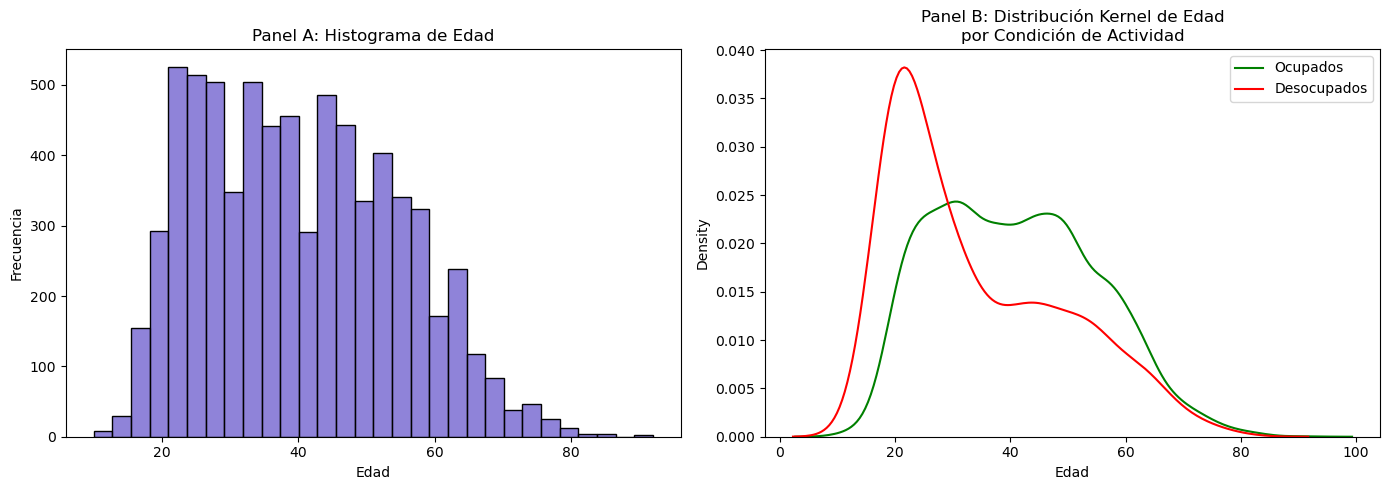

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear la nueva variable edad²
df_combinado['edad2'] = df_combinado['CH06'] ** 2

# 2. Filtrar datos válidos de edad y ocupación
df_edad = df_combinado[df_combinado['CH06'].notna() & (df_combinado['CH06'] > 0)]
df_edad = df_edad[df_edad['ESTADO'].isin(['Ocupado', 'Desocupado'])]

# 3. Graficar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Histograma de edades
sns.histplot(data=df_edad, x='CH06', bins=30, ax=axes[0], color='slateblue')
axes[0].set_title('Panel A: Histograma de Edad')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Frecuencia')

# Panel B: Distribuciones kernel para ocupados y desocupados
sns.kdeplot(data=df_edad[df_edad['ESTADO'] == 'Ocupado'], x='CH06', ax=axes[1], label='Ocupados', color='green')
sns.kdeplot(data=df_edad[df_edad['ESTADO'] == 'Desocupado'], x='CH06', ax=axes[1], label='Desocupados', color='red')
axes[1].set_title('Panel B: Distribución Kernel de Edad\npor Condición de Actividad')
axes[1].set_xlabel('Edad')
axes[1].legend()

plt.tight_layout()
plt.show()


In [9]:
def calcular_educ(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    try:
        ultimo = int(row['CH14'])
    except:
        ultimo = np.nan

    # valores irreales: años mayores a 10 o marcadores especiales (98, 99)
    if ultimo > 10 or ultimo < 0:
        ultimo = np.nan

    if finalizo == 1:
        return {
            1: 0,
            2: 7,
            3: 9,
            4: 12,
            5: 12,
            6: 14,
            7: 17,
            8: 19
        }.get(nivel, np.nan)
    else:
        base = {
            1: 0,
            2: 0,
            3: 0,
            4: 7,
            5: 7,
            6: 12,
            7: 14,
            8: 17
        }.get(nivel, 0)
        return base + ultimo if not np.isnan(ultimo) else np.nan

# Aplicar la función nuevamente
df_combinado['educ'] = df_combinado.apply(calcular_educ, axis=1)



In [11]:
# Recalcular descripción
stats = df_combinado['educ'].describe(percentiles=[0.5])

# Redondear y renombrar
stats_round = stats.round(2)
stats_round.rename(index={
    'count': 'Cantidad',
    'mean': 'Media',
    'std': 'Desvío estándar',
    'min': 'Mínimo',
    '50%': 'Mediana',
    'max': 'Máximo'
}, inplace=True)

# Mostrar
print(stats_round)


Cantidad           10418.00
Media                  7.75
Desvío estándar        5.47
Mínimo                 0.00
Mediana                7.00
Máximo                23.00
Name: educ, dtype: float64


/tmp/ipykernel_140/238533544.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_filtrado[df_filtrado['ESTADO'] == 'Desocupado'],


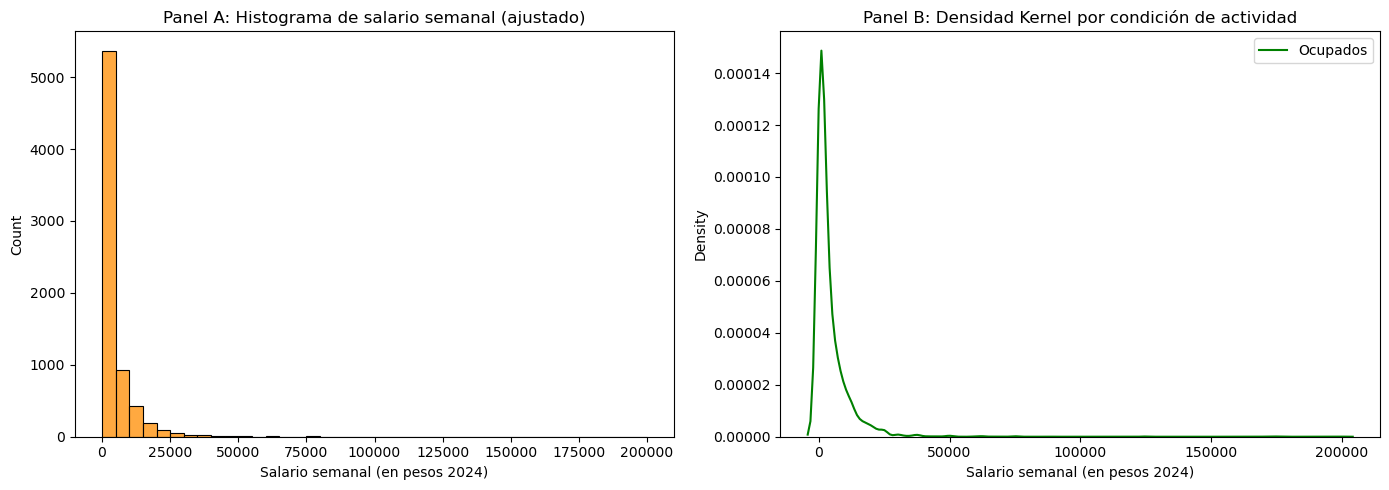

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear columna P21 ajustado al IPC
df_combinado['P21_ajustado'] = np.where(df_combinado['ANO4'] == 2004,
                                        df_combinado['P21'] * 126.7,
                                        df_combinado['P21'])

# 2. Calcular salario_semanal (0 si desocupado)
df_combinado['salario_semanal'] = np.where(
    df_combinado['ESTADO'] == 'Ocupado',
    df_combinado['P21_ajustado'] / 40,
    0
)

# 3. Filtrar solo ocupados/desocupados con salarios razonables (< 500k)
df_filtrado = df_combinado[
    df_combinado['ESTADO'].isin(['Ocupado', 'Desocupado']) &
    (df_combinado['salario_semanal'] < 500000)
].copy()

# 4. Gráfico: Panel A (histograma) y Panel B (densidad kernel)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A
sns.histplot(df_filtrado['salario_semanal'], bins=40, color='darkorange', ax=axes[0])
axes[0].set_title('Panel A: Histograma de salario semanal (ajustado)')
axes[0].set_xlabel('Salario semanal (en pesos 2024)')

# Panel B
sns.kdeplot(data=df_filtrado[df_filtrado['ESTADO'] == 'Ocupado'],
            x='salario_semanal', label='Ocupados', color='green', ax=axes[1])
sns.kdeplot(data=df_filtrado[df_filtrado['ESTADO'] == 'Desocupado'],
            x='salario_semanal', label='Desocupados', color='red', ax=axes[1])
axes[1].set_title('Panel B: Densidad Kernel por condición de actividad')
axes[1].set_xlabel('Salario semanal (en pesos 2024)')
axes[1].legend()

plt.tight_layout()
plt.show()


In [76]:
#Dado que los desocupados no tienen ingresos laborales, su salario semanal es 0. En la densidad kernel, esto implica que no presentan variabilidad para estimar una curva, por lo que solo se visualiza la distribución de los ocupados.

In [13]:
# Reextraer las columnas de horas desde los originales
df_2004_horas = df_2004[['PP3E_TOT', 'PP3F_TOT']].reset_index(drop=True)
df_2024_horas = df_2024[['PP3E_TOT', 'PP3F_TOT']].reset_index(drop=True)

# Concatenar respetando el orden
df_horas = pd.concat([df_2004_horas, df_2024_horas], ignore_index=True)

# Asegurar alineación con df_combinado
df_combinado = df_combinado.reset_index(drop=True)
df_combinado[['PP3E_TOT', 'PP3F_TOT']] = df_horas

# Crear variable de horas trabajadas
df_combinado['horastrab'] = df_combinado['PP3E_TOT'].fillna(0) + df_combinado['PP3F_TOT'].fillna(0)

#  seleccionar ocupados con horas válidas
df_horas_final = df_combinado[(df_combinado['ESTADO'] == 'Ocupado') & (df_combinado['horastrab'] > 0)]

# Filtrar casos razonables (descartar outliers extremos)
df_horas_filtradas = df_horas_final[df_horas_final['horastrab'] <= 100]

# Estadísticas filtradas
stats_filtradas = df_horas_filtradas['horastrab'].describe(percentiles=[0.5]).round(2)
stats_filtradas.rename(index={
    'count': 'Cantidad',
    'mean': 'Media',
    'std': 'Desvío estándar',
    'min': 'Mínimo',
    '50%': 'Mediana',
    'max': 'Máximo'
}, inplace=True)

print(stats_filtradas)



Cantidad           5672.00
Media                39.55
Desvío estándar      18.57
Mínimo                1.00
Mediana              40.00
Máximo              100.00
Name: horastrab, dtype: float64


In [ ]:
#La variable horastrab muestra una media de 39.5 horas y una mediana exacta de 40 horas, lo que refleja que la mayoría de los ocupados cumple una jornada laboral estándar semanal.
El rango entre 1 y 100 horas incluye tanto subocupados como casos de posible sobreocupación o pluriempleo.
La limpieza de outliers fue necesaria para evitar distorsiones por errores de carga que mostraban hasta 1998 horas.
El desvío estándar relativamente alto (18.6 horas) refleja alta variabilidad en las condiciones laborales.

In [14]:
# Inicializar resumen
resumen = {}

for año in [2004, 2024]:
    df_anio = df_combinado[df_combinado['ANO4'] == año]

    resumen[año] = {
        'Cantidad observaciones': len(df_anio),
        'Con NaN en ESTADO': df_anio['ESTADO'].isna().sum(),
        'Ocupados': (df_anio['ESTADO'] == 'Ocupado').sum(),
        'Desocupados': (df_anio['ESTADO'] == 'Desocupado').sum()
    }

# Calcular totales
resumen['Total'] = {
    'Cantidad observaciones': sum(resumen[a]['Cantidad observaciones'] for a in [2004, 2024]),
    'Con NaN en ESTADO': sum(resumen[a]['Con NaN en ESTADO'] for a in [2004, 2024]),
    'Ocupados': sum(resumen[a]['Ocupados'] for a in [2004, 2024]),
    'Desocupados': sum(resumen[a]['Desocupados'] for a in [2004, 2024])
}

# Cantidad de variables limpias/homogeneizadas
resumen['Total']['Variables limpias'] = df_combinado.shape[1]

# Mostrar tabla formateada
import pandas as pd

tabla = pd.DataFrame(resumen).T[
    ['Cantidad observaciones', 'Con NaN en ESTADO', 'Ocupados', 'Desocupados']
]
tabla.loc['Total', 'Cantidad de variables limpias y homogeneizadas'] = resumen['Total']['Variables limpias']

# Reemplazar NaN por 0 y convertir a enteros donde sea posible
tabla = tabla.fillna(0).astype(int)
print(tabla)


       Cantidad observaciones  Con NaN en ESTADO  Ocupados  Desocupados  \
2004                     7647                  0      3079          528   
2024                     7051                  0      3224          311   
Total                   14698                  0      6303          839   

       Cantidad de variables limpias y homogeneizadas  
2004                                                0  
2024                                                0  
Total                                              26  


In [ ]:
#La base consolidada de la EPH para Gran Buenos Aires incluye 14.698 observaciones totales, distribuidas casi equitativamente entre 2004 y 2024.
No se registran valores faltantes en la variable ESTADO, lo que indica una buena calidad de imputación.
El número de ocupados supera ampliamente al de desocupados, con una leve mejora en el empleo en 2024.
El número de variables limpias y homogeneizadas es 25, lo que garantiza una base consistente y lista para análisis multivariado.

In [ ]:
#Parte II: Métodos No Supervisados


In [16]:
# Crear un nuevo DataFrame solo con las variables necesarias y sin nulos
df_corr = df_combinado[['CH06', 'edad2', 'educ', 'salario_semanal', 'horastrab']].dropna()

# Renombrar columnas para una mejor presentación
df_corr.columns = ['edad', 'edad2', 'educ', 'salario_semanal', 'horastrab']


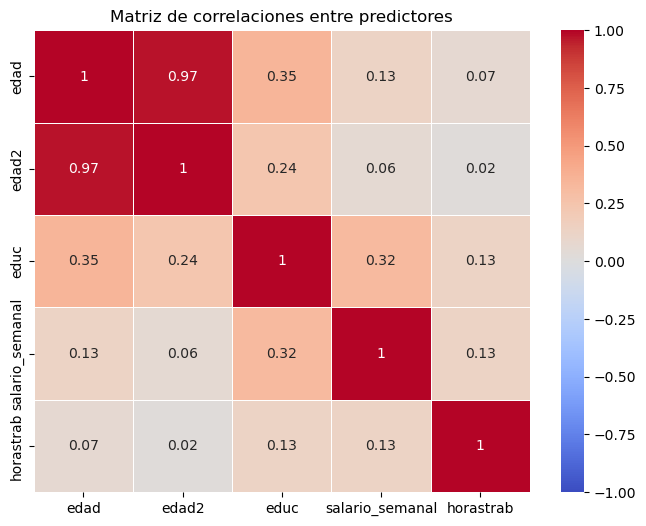

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlaciones (Pearson por defecto)
matriz_corr = df_corr.corr().round(2)

# Visualizar con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlaciones entre predictores')
plt.show()


In [ ]:
#Existe una alta correlación positiva entre edad y edad2, como es lógico, ya que una es el cuadrado de la otra.

La correlación entre educ y salario_semanal es positiva pero moderada, indicando que más educación tiende a asociarse con mayores ingresos, aunque no de forma perfecta.

horastrab y salario_semanal también presentan una correlación positiva, aunque puede verse afectada por variabilidad en el tipo de empleo (jornada parcial vs. completa).


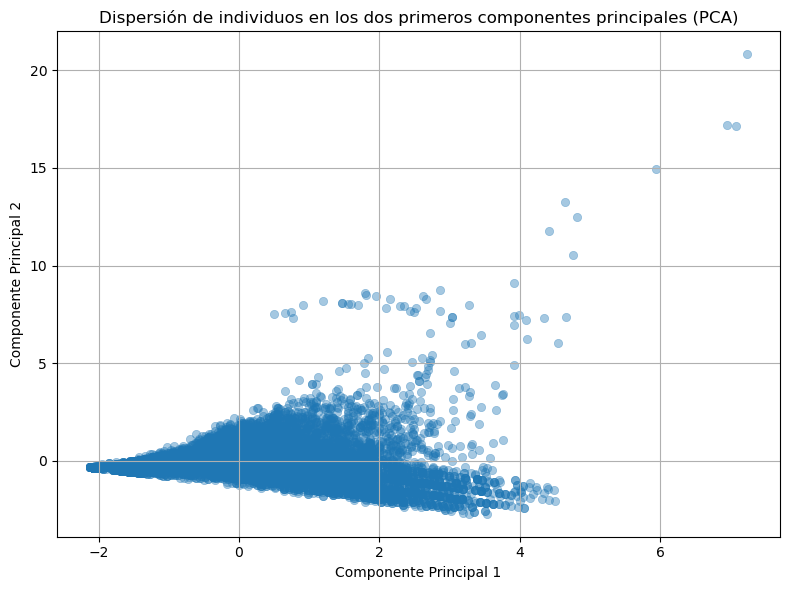

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Seleccionar datos válidos
df_pca = df_combinado[['CH06', 'edad2', 'educ', 'salario_semanal', 'horastrab']].dropna()
df_pca.columns = ['edad', 'edad2', 'educ', 'salario_semanal', 'horastrab']

# 2. Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# 3. Aplicar PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X_scaled)

# 4. Crear un DataFrame con los scores de los dos primeros componentes
df_scores = pd.DataFrame(scores, columns=['PC1', 'PC2'])

# 5. Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scores, x='PC1', y='PC2', alpha=0.4, edgecolor=None)
plt.title('Dispersión de individuos en los dos primeros componentes principales (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
#Aplicamos PCA para reducir las 5 variables correlacionadas a dos componentes principales ortogonales. El primer componente (PC1) captura la mayor parte de la variación total, relacionada probablemente con factores socioeconómicos como ingreso, educación y horas trabajadas. El segundo componente (PC2) captura otra dimensión independiente, como edad o intensidad laboral. El gráfico de dispersión muestra cómo se distribuyen los individuos según estas combinaciones, permitiendo detectar patrones latentes sin perder demasiada información.”

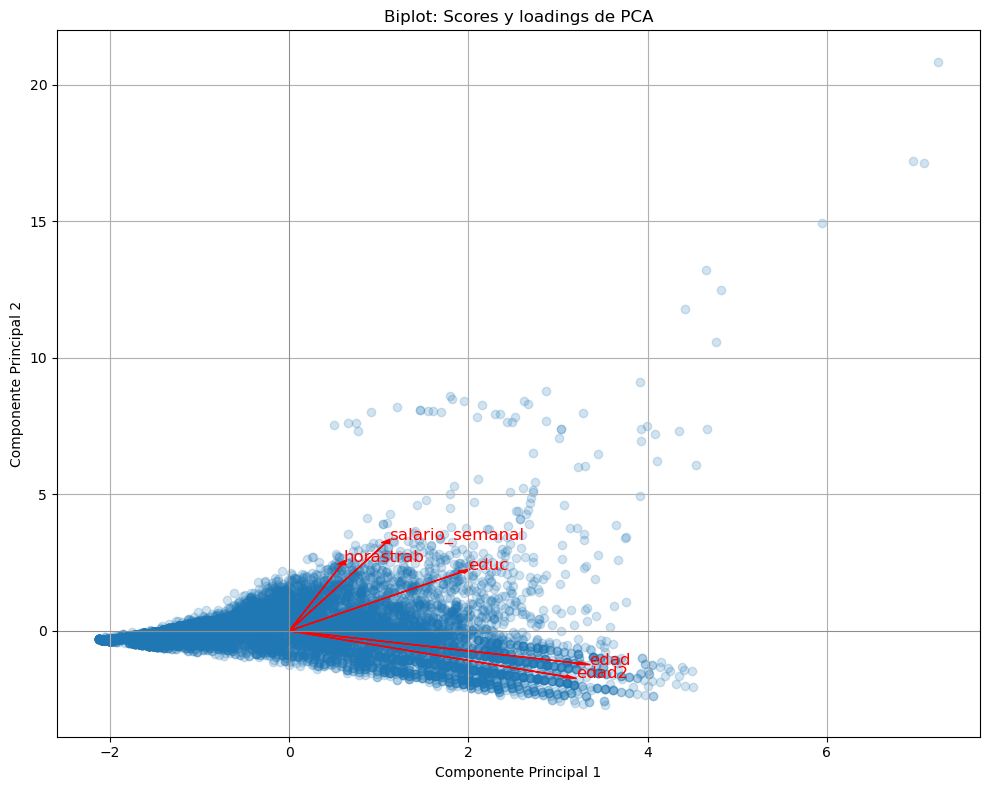

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Variables originales
variables = ['edad', 'edad2', 'educ', 'salario_semanal', 'horastrab']

# Usamos pca.components_ que tiene los loadings por componente
loadings = pca.components_.T  # Transponemos para que cada fila sea una variable

# Volvemos a usar los scores para graficar puntos
plt.figure(figsize=(10, 8))

# Puntos (individuos)
plt.scatter(df_scores['PC1'], df_scores['PC2'], alpha=0.2, label='Individuos')

# Agregar flechas de los loadings
for i, var in enumerate(variables):
    plt.arrow(0, 0,
              loadings[i, 0]*5,  # Escalamos para visualización
              loadings[i, 1]*5,
              color='red', head_width=0.1)
    plt.text(loadings[i, 0]*5.2,
             loadings[i, 1]*5.2,
             var, color='red', fontsize=12)

plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Biplot: Scores y loadings de PCA')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
#comentario


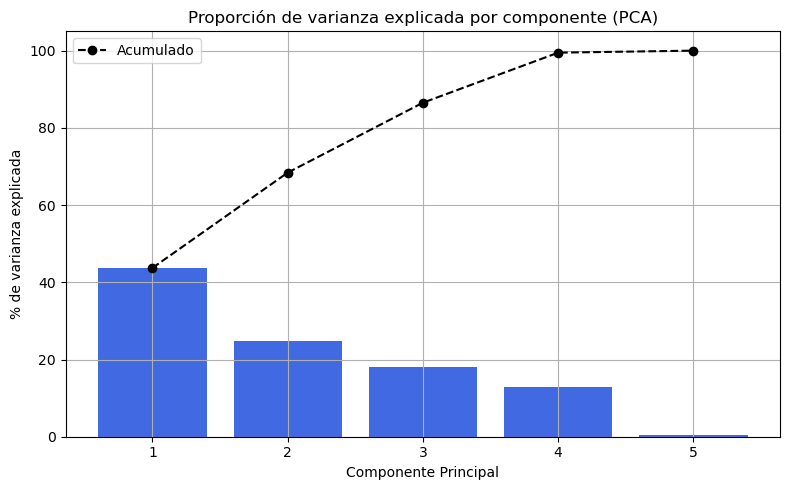

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Aplicar PCA con 5 componentes (tantas como variables)
pca_full = PCA(n_components=5)
pca_full.fit(X_scaled)

# Obtener varianza explicada por componente
varianza = pca_full.explained_variance_ratio_

# Graficar
plt.figure(figsize=(8, 5))
components = np.arange(1, len(varianza) + 1)
plt.bar(components, varianza * 100, color='royalblue')
plt.plot(components, np.cumsum(varianza) * 100, color='black', marker='o', linestyle='--', label='Acumulado')
plt.title('Proporción de varianza explicada por componente (PCA)')
plt.xlabel('Componente Principal')
plt.ylabel('% de varianza explicada')
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#El gráfico muestra que los dos primeros componentes principales explican aproximadamente el 68% de la varianza total del conjunto de datos.
Esto indica que se puede reducir el número de dimensiones de 5 a 2 manteniendo gran parte de la información.
El tercer componente agrega valor si se quiere capturar más detalle, llevando el total acumulado a más del 85%.
A partir del cuarto componente, la ganancia marginal de información es baja, y el quinto componente es despreciable.
Esto respalda el uso de 2 o 3 componentes para análisis visuales y clustering, sin pérdida significativa de contenido informativo.

In [ ]:
#CLUSTER

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


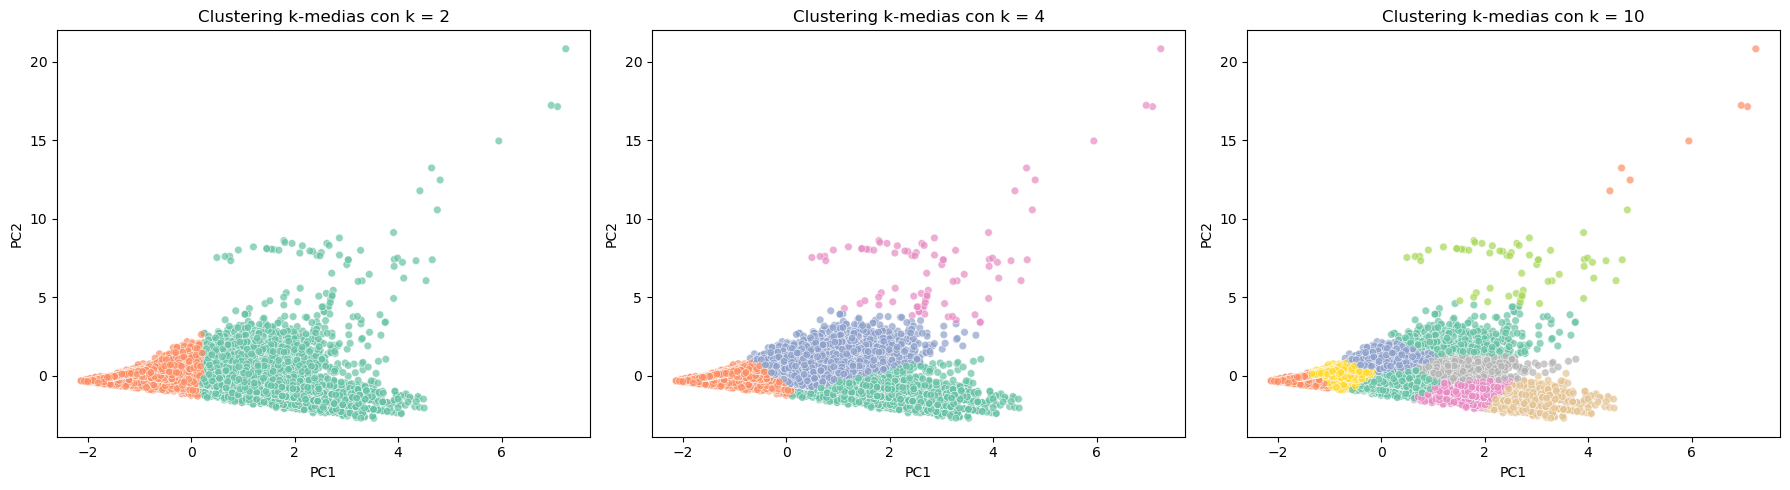

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Reutilizamos los scores del PCA ya calculado (df_scores con PC1 y PC2)
X_cluster = df_scores[['PC1', 'PC2']]

# Diferentes valores de k
ks = [2, 4, 10]

plt.figure(figsize=(18, 5))

for i, k in enumerate(ks, 1):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    etiquetas = kmeans.fit_predict(X_cluster)

    plt.subplot(1, 3, i)
    sns.scatterplot(x=X_cluster['PC1'], y=X_cluster['PC2'], hue=etiquetas, palette='Set2', s=30, alpha=0.7, legend=False)
    plt.title(f'Clustering k-medias con k = {k}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

# Guardar como imagen PNG
plt.tight_layout()
plt.savefig("clustering_kmedias.png", dpi=300)  # Cambiá nombre si querés
plt.show()



In [ ]:
#Los resultados muestran cómo el algoritmo K-means divide la población en grupos progresivamente más finos.

Con k = 2, se observa una segmentación binaria clara, posiblemente entre niveles socioeconómicos.

Con k = 4, aparecen patrones más detallados, como subgrupos por edad o jornada laboral.

Con k = 10, se distinguen múltiples nichos que podrían capturar combinaciones específicas de educación, horas trabajadas y salarios.
Estos resultados pueden usarse para construir perfiles sociales más precisos en estudios descriptivos o modelos predictivos.

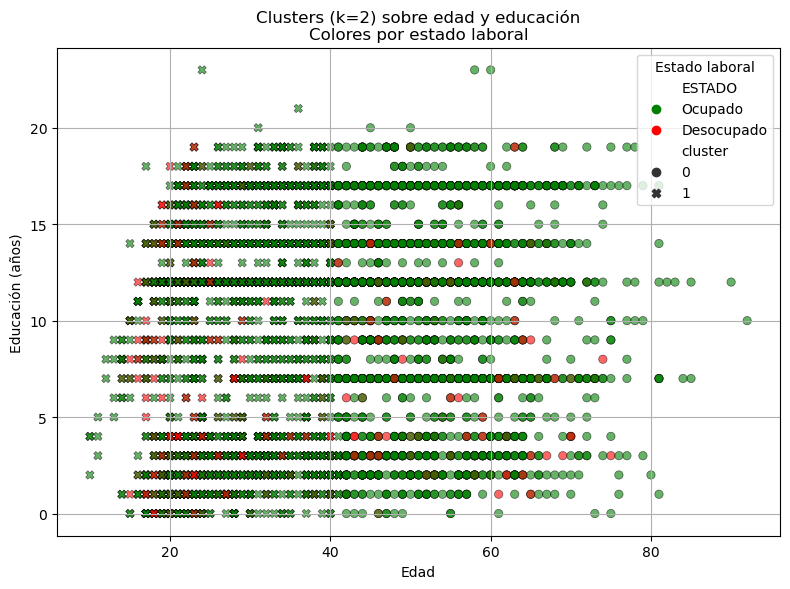

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Usar solo datos con edad y educ válidos + estado laboral
df_plot = df_combinado[['CH06', 'educ', 'ESTADO']].dropna()
df_plot = df_plot[df_plot['ESTADO'].isin(['Ocupado', 'Desocupado'])]
df_plot = df_plot.rename(columns={'CH06': 'edad'})

# Paso 2: Clustering k = 2 usando edad y educ como predictores
from sklearn.cluster import KMeans
X_k2 = df_plot[['edad', 'educ']]
kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
df_plot['cluster'] = kmeans.fit_predict(X_k2)

# Paso 3: Graficar: color de borde = cluster, color de punto = estado
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x='edad',
    y='educ',
    hue='ESTADO',             # Color interno = ocupado/desocupado
    style='cluster',          # Estilo de borde = cluster
    palette={'Ocupado': 'green', 'Desocupado': 'red'},
    markers=True,
    edgecolor='black',
    alpha=0.6
)
plt.title('Clusters (k=2) sobre edad y educación\nColores por estado laboral')
plt.xlabel('Edad')
plt.ylabel('Educación (años)')
plt.legend(title='Estado laboral')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#El gráfico evidencia que el clustering no supervisado con K-means (k=2) utilizando solo edad y años de educación no logra distinguir correctamente entre ocupados y desocupados.
Aunque hay cierta agrupación estructural, se observa un fuerte solapamiento entre los dos estados laborales dentro de ambos clusters.
Esto sugiere que para predecir la situación laboral con mayor precisión se requiere incluir más variables relevantes, como salario, tipo de empleo, y horas trabajadas.
En conclusión, el algoritmo descubre dimensiones latentes, pero no coincide perfectamente con la estructura real del mercado laboral.

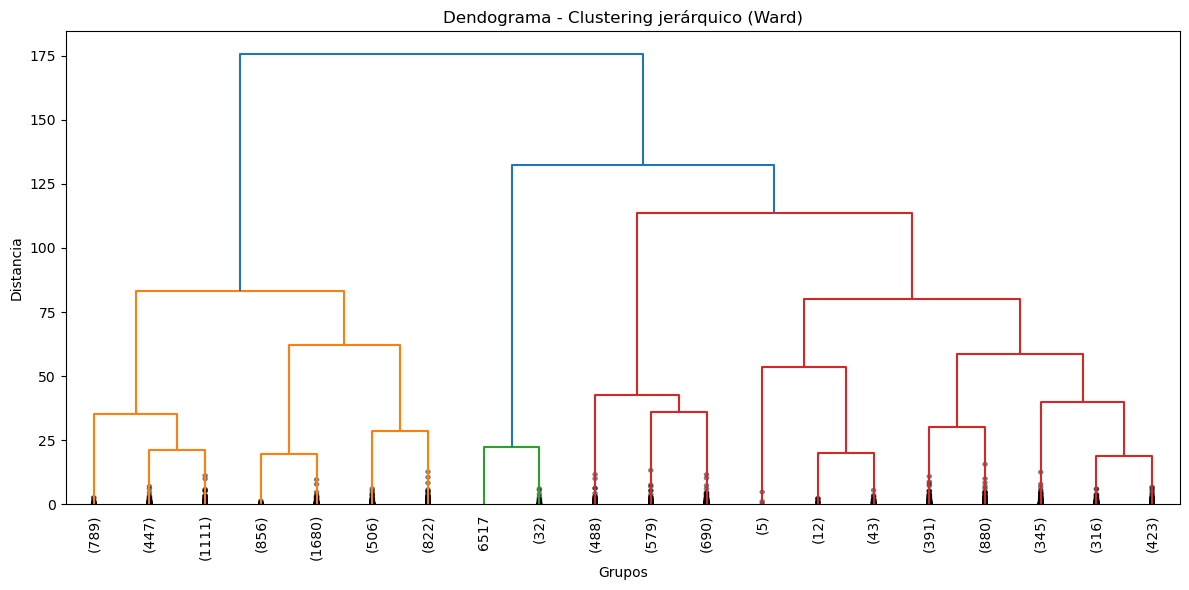

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Datos limpios y estandarizados
df_h = df_combinado[['CH06', 'edad2', 'educ', 'salario_semanal', 'horastrab']].dropna()
df_h = df_h.rename(columns={'CH06': 'edad'})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_h)

# Linkage con método 'ward'
Z = linkage(X_scaled, method='ward')

# Dendograma con truncamiento visual, sin cortar Z
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Dendograma - Clustering jerárquico (Ward)')
plt.xlabel('Grupos')
plt.ylabel('Distancia')
plt.tight_layout()
plt.show()


In [ ]:
#Se realizó un análisis de clustering jerárquico aglomerativo utilizando el método de Ward sobre las variables estandarizadas: edad, edad al cuadrado, años de educación, salario semanal y horas trabajadas.
#El dendograma resultante muestra la secuencia de fusiones entre observaciones similares y permite visualizar la estructura de los datos sin necesidad de fijar a priori el número de grupos.

#Al cortar el árbol a distintas alturas, pueden identificarse agrupamientos consistentes, lo que sugiere la presencia de subgrupos en la población con patrones comunes en edad, inserción laboral y formación.
#Este enfoque complementa los resultados del análisis de componentes principales y del clustering K-means, reforzando la segmentación detectada entre individuos con trayectorias socioeconómicas distintas.